In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import holidays
from sklearn.model_selection import train_test_split

# Load the data
data_RF = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/imputed_data_RF.csv")
data_KNN = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/imputed_data_KNN.csv")

## Daten vorbereiten

In [9]:
# Define categorical features
categorical_features = ["Warengruppe", "Feiertag", "Monat", "Kieler_Woche", "Wochenende", "Wochentag", "Wettercode", "Bewoelkung_kat", "Windgeschwindigkeit_kat", "Kalenderwoche", "Jahreszeit", "Feiertag_in_3_tagen", "Temp_abw"]

# Inspect data_KNN types and unique values for categorical columns
print(data_KNN[categorical_features].dtypes)
print("Unique Values:\n", data_KNN[categorical_features].apply(lambda x: x.unique()))

# Ensure categorical columns are treated as categories
for col in categorical_features:
    data_KNN[col] = data_KNN[col].astype('category')

# Encode categorical variables using pd.get_dummies
features = pd.get_dummies(data_KNN[categorical_features], drop_first=True, dtype=int)

# Include any numeric columns that are not categorical
numeric_features = ["Windgeschwindigkeit", "Temperatur", "Bewoelkung", "Umsatz_lag1", "Umsatz_lag7", "Datum"]
for col in numeric_features:
    features[col] = data_KNN[col]

# Construct the prepared data_KNN set including the dependent variable ('label')
prepared_data = pd.concat([data_KNN[['Umsatz']], features], axis=1)

# Handle missing values by removing rows with any missing values
prepared_data = prepared_data.dropna()

# Display the shape of the prepared data_KNN set
print(prepared_data.shape)

# Display the first few rows of the prepared data_KNN set
print(prepared_data.head())


Warengruppe                category
Feiertag                   category
Monat                      category
Kieler_Woche               category
Wochenende                 category
Wochentag                  category
Wettercode                 category
Bewoelkung_kat             category
Windgeschwindigkeit_kat    category
Kalenderwoche              category
Jahreszeit                 category
Feiertag_in_3_tagen        category
Temp_abw                   category
dtype: object
Unique Values:
 Warengruppe                [3.8, 3.0, 3.0, 3.8, 3.0, ..., 3.0, 3.0, 3.0, ...
Feiertag                      [1.0, 0.0]
Categories (2, float64): [0.0, 1.0]
Monat                      [1.0, 2.0, 3.0, 4.0, 5.0, ..., 8.0, 9.0, 10.0,...
Kieler_Woche                  [0.0, 1.0]
Categories (2, float64): [0.0, 1.0]
Wochenende                    [1.0, 0.0]
Categories (2, float64): [0.0, 1.0]
Wochentag                  [6.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Categories...
Wettercode                 [58.000000, 6

## Daten aufteilen

In [11]:
import os
import pandas as pd

# Daten mit Zeitreihenstruktur aufteilen
# Ensure the data is sorted by date
data = prepared_data.sort_values(by='Datum').dropna()
print(prepared_data.head())

# Define your date thresholds
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'

# Split the data based on the date thresholds
train_data = data[data['Datum'] <= train_end_date]
validation_data = data[(data['Datum'] > train_end_date) & (data['Datum'] <= validation_end_date)]
test_data = data[data['Datum'] > validation_end_date]

# Seperate the features and labels
# Separating features and labels
training_features = train_data.drop('Umsatz', axis=1)
validation_features = validation_data.drop('Umsatz', axis=1)
test_features = test_data.drop('Umsatz', axis=1)

training_labels = train_data[['Umsatz']]
validation_labels = validation_data[['Umsatz']]
test_labels = test_data[['Umsatz']]


# Check the dimensions of the datasets
print("Training dataset dimensions:", train_data.shape)
print("Validation dataset dimensions:", validation_data.shape)
print("Test dataset dimensions:", test_data.shape)


       Umsatz  Warengruppe_0.9999999665865544  Warengruppe_0.9999999742719  \
0  114.234794                               0                            0   
1  179.073824                               0                            0   
2  156.975990                               0                            0   
3  154.468579                               0                            0   
4  140.018154                               0                            0   

   Warengruppe_1.0  Warengruppe_1.000000011377524  \
0                0                              0   
1                0                              0   
2                0                              0   
3                0                              0   
4                0                              0   

   Warengruppe_1.000000023012275  Warengruppe_1.0000000392415644  \
0                              0                               0   
1                              0                               0   
2       

## Daten speichern

In [12]:
# Define the file paths
subdirectory = "pickle_data"
if not os.path.exists(subdirectory):
    os.makedirs(subdirectory)

training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Assuming 'Umsatz' is the label and the rest are features
train_features = train_data.drop(columns=['Umsatz'])
train_labels = train_data['Umsatz']
validation_features = validation_data.drop(columns=['Umsatz'])
validation_labels = validation_data['Umsatz']
test_features = test_data.drop(columns=['Umsatz'])
test_labels = test_data['Umsatz']

# Save the datasets to pickle files
train_features.to_pickle(training_features_path)
train_labels.to_pickle(training_labels_path)
validation_features.to_pickle(validation_features_path)
validation_labels.to_pickle(validation_labels_path)
test_features.to_pickle(test_features_path)
test_labels.to_pickle(test_labels_path)

# Verify the saved data by reading the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())

Loaded Training features dimensions: (8070, 1539)
Loaded Validation features dimensions: (1849, 1539)
Loaded Test features dimensions: (366, 1539)

Loaded Training labels dimensions: (8070,)
Loaded Validation labels dimensions: (1849,)
Loaded Test labels dimensions: (366,)

First few rows of loaded training features:
   Warengruppe_0.9999999665865544  Warengruppe_0.9999999742719  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   

   Warengruppe_1.0  Warengruppe_1.000000011377524  \
0                0                              0   
1                0                              0   
2                0                              0   
3                0                              0   
4                0 

## Daten zu numpy arrays machen

In [13]:
# Convert DataFrames to numpy arrays
training_features_array = training_features.to_numpy()
training_labels_array = training_labels.to_numpy().flatten()  # Flatten in case labels are a DataFrame with one column

print("Training Features Array:")
print(training_features_array[:5])

Training Features Array:
[[0 0 0 ... 979.664032371759 130.8197102818178 '2012-01-01']
 [0 0 0 ... 178.06834398765776 228.6564918468304 '2012-01-02']
 [0 0 0 ... 162.7664935402656 507.23326134746816 '2012-01-03']
 [0 0 0 ... 270.25101522683565 210.1287755101419 '2012-01-04']
 [0 0 0 ... 131.27206779742895 173.27369159797396 '2012-01-05']]


## Aufstellen des Modells

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam


model = Sequential([
  InputLayer(input_shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(128, activation='relu'),
  Dropout(.3),
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(1)
])

model.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_12          │ (None, 1538)           │         6,152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,513 (834.04 KB)

 Trainable params: 210,437 (822.02 KB)

 Non-trainable params: 3,076 (12.02 KB)

## Modell trainieren

In [37]:
# Funktion zur Entfernung von nicht-numerischen Spalten und Konvertierung
def preprocess_data(df):
    # Entfernen von datetime-Spalten
    df = df.select_dtypes(exclude=['datetime64[ns]'])
    # Konvertieren von allen verbleibenden Spalten zu numerischen Werten
    df = df.apply(pd.to_numeric, errors='coerce')
    # Entfernen von Spalten, die nach der Konvertierung nur noch NaNs enthalten
    df = df.dropna(axis=1, how='all')
    return df

# Vorverarbeitung der Daten
training_features = preprocess_data(training_features)
validation_features = preprocess_data(validation_features)
test_features = preprocess_data(test_features)

# Sicherstellen, dass alle Spalten numerisch sind
print("Datentypen der Trainingsdaten:")
print(training_features.dtypes)

# Sicherstellen, dass die Daten vorbereitet sind
print("Training features shape:", training_features.shape)

# Beispiel für die Erstellung eines einfachen neuronalen Netzwerks
# InputLayer an die Anzahl der Merkmale anpassen
model = Sequential([
    InputLayer(input_shape=(training_features.shape[1],)),  # Anzahl der Merkmale dynamisch anpassen
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1)  # Ausgabe-Neuron für die Regression
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Modell trainieren
history = model.fit(training_features, training_labels, epochs=2,
                    validation_data=(validation_features, validation_labels))

print("Modell erfolgreich trainiert!")




Datentypen der Trainingsdaten:
Warengruppe_0.9999999665865544      int64
Warengruppe_0.9999999742719         int64
Warengruppe_1.0                     int64
Warengruppe_1.000000011377524       int64
Warengruppe_1.000000023012275       int64
                                   ...   
Windgeschwindigkeit               float64
Temperatur                        float64
Bewoelkung                        float64
Umsatz_lag1                       float64
Umsatz_lag7                       float64
Length: 1538, dtype: object
Training features shape: (8070, 1538)
Epoch 1/2


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 43272.5664 - val_loss: 7518.2944
Epoch 2/2
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7154.4976 - val_loss: 3086.2480
Modell erfolgreich trainiert!


## Modell speichern

In [38]:
model.save("python_model.h5")

## Modell Loss durchs Training plotten

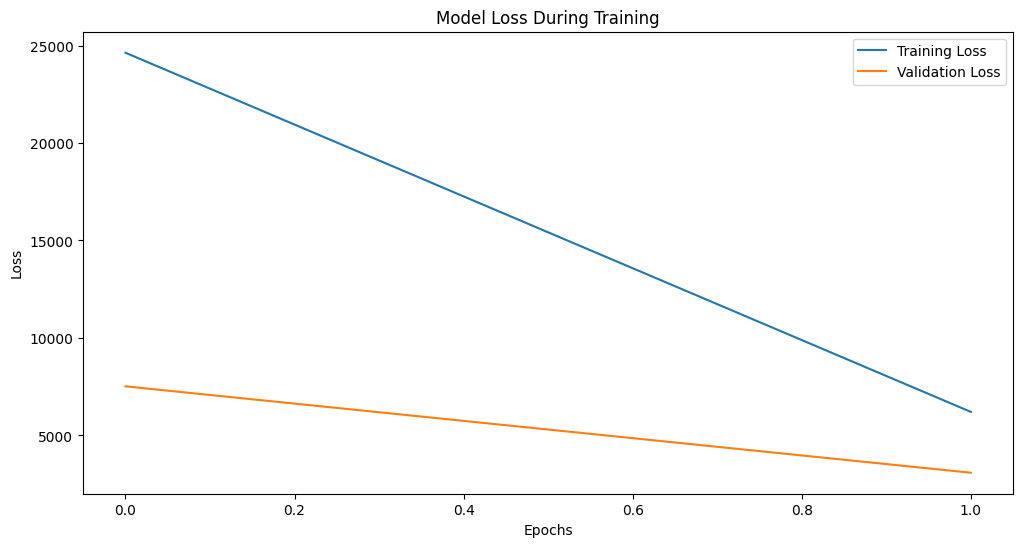

In [39]:
# Training history plotten
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predicitions aufstellen

In [40]:
# Predictions machen
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
MAPE on the Training Data: 92.91%
MAPE on the Validation Data: 95.24%


## Predictions plotten

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


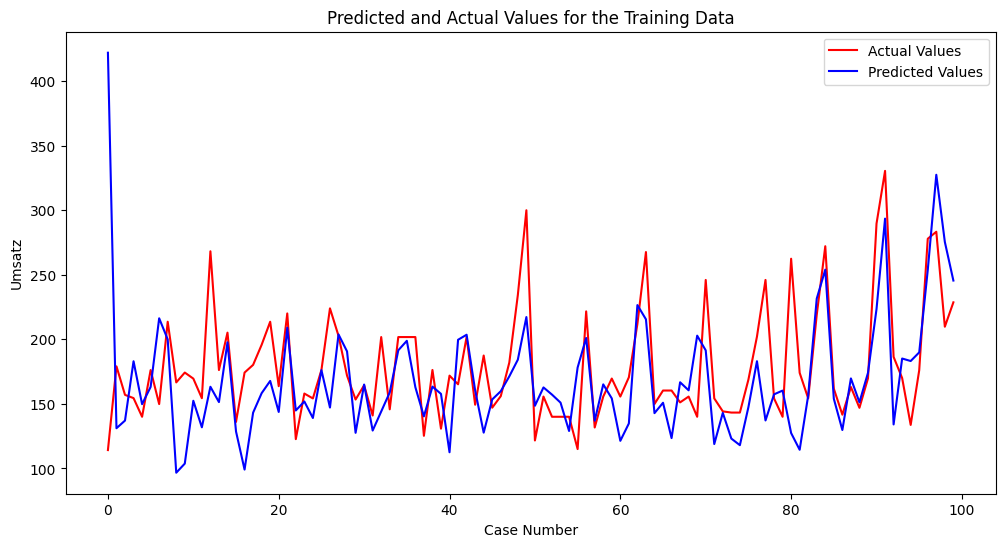

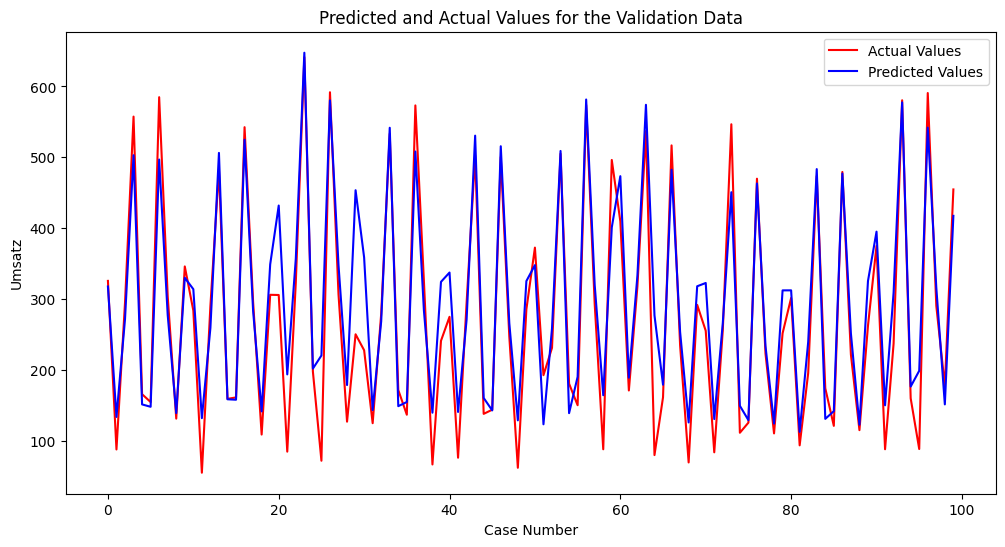

In [41]:
# Plotten
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')